In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

sys.path.insert(0, "../")

import warnings
warnings.filterwarnings('ignore')

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

In [3]:
index = 50

In [4]:
j = janet.boot(uni, index=index, use_prior=False)
j.prepare_data()

Already have data downloaded for Gaia ID 2200113593132819200.
If you want to check for new data, run `janet.update()`.


In [6]:
j.data.build_unpopular_lc()

Removing 3 bad data points (out of 1121) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median
Removing 4 bad data points (out of 1130) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median


In [8]:
list(j.void)

['datum_16',
 'clc_16',
 'datum_17',
 'clc_17',
 'clc_all',
 'clc_16-17',
 'cpmlc_16',
 'cpm_16',
 'cpmlc_17',
 'cpm_17',
 'cpmlc_16-17']

<AxesSubplot:xlabel='Time [JD]', ylabel='Normalized Flux'>

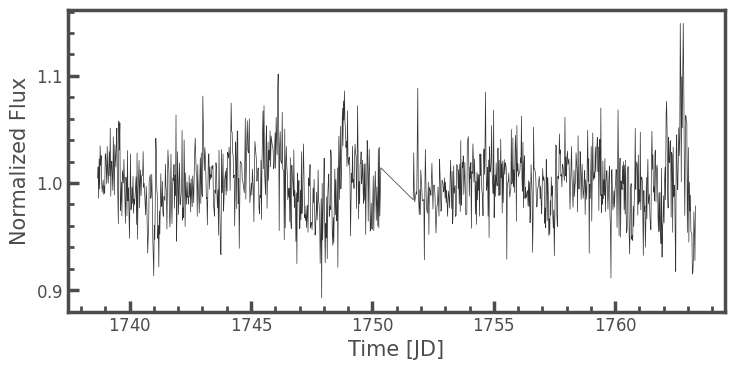

In [14]:
j.void['clc_16'].plot()

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

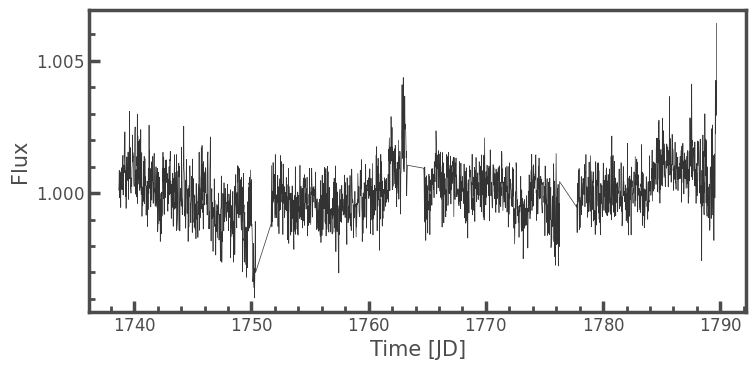

In [12]:
# ax = j.void['clc_16-17'].plot()
j.void['cpmlc_16-17'].plot()

In [ ]:
import glob
import tess_cpm
from astropy.coordinates import SkyCoord
import astropy.units as u
import eleanor
import lightkurve as lk
rastr = str(j.ra)
step = len(rastr.split('.')[0])
decstr = str(j.dec)
step = len(decstr.split('.')[0])
sfiles = np.sort(glob.glob(f'/Users/oliver hall/.eleanor/tesscut/*_{rastr[:(7+step)]}*{decstr[:(7+step)]}_*'))
coords = SkyCoord(ra = j.ra, dec = j.dec, unit = (u.deg, u.deg))

# Set up a standard aperture based on the `eleanor` aperture for a 50x50
# postcard.
for sfile, s in zip(sfiles, j.sectorlist):
    cpm = tess_cpm.Source(sfile, remove_bad=True)
    aperture = j.void[f'datum_{s}'].aperture
    rowlims = 20 + np.array([np.where(aperture)[0].min(), np.where(aperture)[0].max()])
    collims = 20 + np.array([np.where(aperture)[1].min(), np.where(aperture)[1].max()])
    cpm.set_aperture(rowlims = rowlims, collims = collims)

    # We use 200 predictors for a stamp of this size. This is a rough
    # guesstimate from trial-and-error, but seems to work well.
    cpm.add_cpm_model(exclusion_size=6, n=200,
        predictor_method = "similar_brightness")
    cpm.set_regs([0.1])
    cpm.holdout_fit_predict(k=100, verbose=False)

    # Save corrected flux as a lightcurve object for this sector
    flux = cpm.get_aperture_lc(data_type="cpm_subtracted_flux",
                                weighting='median')
    j.void[f'cpmlc_{s}'] = lk.LightCurve(time = cpm.time, flux = flux) + 1.


In [ ]:
for s in j.sectors:
    if len(s.split('-')) > 1:
        sectors = np.arange(int(s.split('-')[0]), int(s.split('-')[-1])+1)

        cpmlc = j.void[f'cpmlc_{sectors[0]}']

        for i in sectors[1:]:
            cpmlc = cpmlc.append(j.void[f'cpmlc_{i}'])

        j.void[f'cpmlc_{s}'] = cpmlc


In [ ]:
eleanor.Source(coords=coords, tc=True)

In [ ]:
sys.exit()

In [ ]:
j.run(period_range = (1., 26.))

Make a poserior based on all hte estimates, importance sample based on hte prior to generate a new posterior. Can also weight in favour of eg CACF. 

## graveyard

In [ ]:
sys.exit()


In [ ]:
obs = {
    'Teff' : [uni.loc[index, 'Teff'], uni.loc[index, 'e_Teff']],
    'logg' : [uni.loc[index, 'logg'], uni.loc[index, 'e_logg']],
    'MG' : [uni.loc[index, 'MGna'], uni.loc[index, 'e_MGna']],
    'bp_rp' : [uni.loc[index, 'bp_rp'], uni.loc[index, 'e_bp_rp']]
}

obs['logT'] = [0., 0.]
obs['logT'][0] = np.log10(obs['Teff'][0])
obs['logT'][1] = obs['Teff'][1] / (np.log(10)*obs['Teff'][0])

obs['logbp_rp'] = [0., 0.]
obs['logbp_rp'][0] = np.log10(obs['bp_rp'][0])
obs['logbp_rp'][1] = obs['bp_rp'][1] / (np.log(10)*obs['bp_rp'][0])

# Assume 10% uncertainty in absence of errors
for col in ['Teff','logg','MG','bp_rp']:
    if not np.isfinite(obs[col][1]):
        obs[col][1] = 0.1*obs[col][0]
        
    if not np.isfinite(obs[col][0]):
        obs = None
        use_prior = False
        print('Not enough information to use the prior until we allow for it.')
        break